In [1]:
%pylab inline
import numpy as np
from tqdm import trange


Populating the interactive namespace from numpy and matplotlib


In [2]:
# load the mnist dataset

def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [5]:
def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if not os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [3]:
X_train.reshape(-1, 28*28).shape

(60000, 784)

In [ ]:
imshow(X_train[0]), Y_train[0]

In [3]:
import torch
import torch.nn as nn

class BobNet(nn.Module):
    def __init__(self):
        super(BobNet, self).__init__()
        self.l1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        return x

In [26]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)
class BobNet(torch.nn.Module):
  def __init__(self):
    super(BobNet, self).__init__()
    self.l1 = nn.Linear(784, 128, bias=False)
    self.l2 = nn.Linear(128, 10, bias=False)
    self.sm = nn.LogSoftmax(dim=1)
  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = self.sm(x)
    return x

In [4]:
model = BobNet()
# model(torch.tensor(X_train[0:10]).reshape(-1, 28*28).float())#torch.tensor(X_train[0:10])

In [ ]:
batch_size = 128
loss_function = nn.NLLLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
losses, accuracies = [], []

loop = trange(1000)
for i in loop:
    samp = np.random.randint(0, X_train.shape[0], size=batch_size)
    X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[samp]).long()

    model.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss = loss.mean()
    loss.backward()
    optim.step()

    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    loop.set_description("loss %.2f accurcy %.2f" % (loss, accuracy))


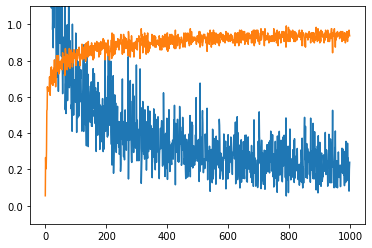

In [27]:
# training
model = BobNet()

# protip: if you like accuracy like 96 not like 93, next time through the notebook, consider
# CHAD MODE WEIGHT INIT WITH NUMPY
# instead of virgin torch init mode
# TODO: why is torch linear init bad?
"""
with torch.no_grad():
  model.l1.weight.copy_(torch.tensor(layer_init(784, 128).T))
  model.l2.weight.copy_(torch.tensor(layer_init(128, 10).T))
"""

loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
BS = 128
losses, accuracies = [], []
t = trange(1000)
for i in t:
  samp = np.random.randint(0, X_train.shape[0], size=(BS))
  X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
  Y = torch.tensor(Y_train[samp]).long()
  model.zero_grad()
  out = model(X)
  cat = torch.argmax(out, dim=1)
  accuracy = (cat == Y).float().mean()
  loss = loss_function(out, Y)
  loss = loss.mean()
  loss.backward()
  optim.step()
  loss, accuracy = loss.item(), accuracy.item()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

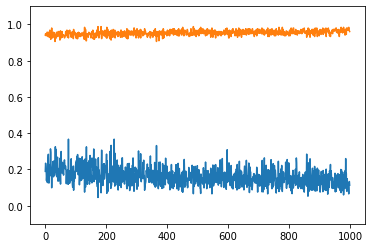

In [8]:
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [28]:
with torch.no_grad():
    Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
    print((Y_test == Y_test_preds).mean())

0.9297


In [54]:
l1 = np.zeros((784, 128), dtype=np.float32)
l2 = np.zeros((128, 10), dtype=np.float32)
l1.dtype, l2.dtype, id(l1), id(l2)

(dtype('float32'), dtype('float32'), 140690983962304, 140690984323712)

In [ ]:
# copy weights from pytorch
l1[:] = model.l1.weight.detach().numpy().transpose().T
l2[:] = model.l2.weight.detach().numpy().transpose().T

In [56]:
X_test[0:32].reshape((-1, 28 * 28)).shape

(32, 784)

In [57]:
# numpy forward pass
def forward(x):
    x = x.dot(l1)
    # x = np.max(0, x)
    x = np.maximum(x, 0)
    x = x.dot(l2)
    return x

In [72]:
Y_test = np.argmax(forward(X_test.reshape((-1, 28 * 28))), axis=1)
print((Y_test == Y_test_preds).mean())

0.9735


In [ ]:
np.argmax(forward(X_test.reshape((-1, 28 * 28))), axis=1).shape

In [ ]:
# training in numpy
